# Asia BN

This notebook is meant for testing the Pearl API on a toy Bayesian Network. This network has 8 binary variables. The "NET" encoding of this model and a simulated dataset generated from it can be found at the following links:
* https://www.bnlearn.com/bnrepository/asia/asia.net.gz
* http://www.ccd.pitt.edu/wiki/images/ASIA10k.csv

In [1]:
from pearl.bayesnet import BayesianNetwork
from pearl.nodes.categorical import CategoricalNodeWithDirichletPrior
from pearl.data import BayesianNetworkDataset, VariableData
from pearl.common import NodeValueType


import torch
from pyro.optim import Adam
import pandas as pd
import graphviz
from time import time
import urllib
import os
import gzip
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Dataset

We get the simulated dataset for the Asia Bayesian Network and package it as a `BayesianNetworkDataset` object.

In [3]:
def converter(x):
    if x == 'yes':
        return 0
    else:
        return 1

try:
    asia_dataset = torch.load("asia_dataset.pkl")
except:    
    df = pd.read_csv(
        "http://www.ccd.pitt.edu/wiki/images/ASIA10k.csv",
        converters = {k:converter for k in range(8)}
    )
    variable_dict = {
        k: VariableData(
            NodeValueType.CATEGORICAL,
            torch.tensor(df[k].to_numpy(), device=device).float(),
            ["yes", "no"],
        )
        for k in df.columns
    }
    asia_dataset = BayesianNetworkDataset(variable_dict)
    torch.save(asia_dataset, "asia_dataset.pkl")

### Split the dataset

In [4]:
num_train_instances = int(len(asia_dataset) * 0.8)
num_test_instances = len(asia_dataset) - num_train_instances
train_dataset, test_dataset = asia_dataset.split((num_train_instances, num_test_instances))

## Define the model

In [5]:
asia_model = BayesianNetwork("asia", device=device)
asia_model.add_variable(CategoricalNodeWithDirichletPrior, "asia", [], [], domain=["yes", "no"])
asia_model.add_variable(CategoricalNodeWithDirichletPrior, "smoke", [], [], domain=["yes", "no"])
asia_model.add_variable(CategoricalNodeWithDirichletPrior, "tub", ["asia"], [], domain=["yes", "no"])
asia_model.add_variable(CategoricalNodeWithDirichletPrior, "lung", ["smoke"], [], domain=["yes", "no"])
asia_model.add_variable(CategoricalNodeWithDirichletPrior, "either", ["lung", "tub"], [], domain=["yes", "no"])
asia_model.add_variable(CategoricalNodeWithDirichletPrior, "bronc", ["smoke"], [], domain=["yes", "no"])
asia_model.add_variable(CategoricalNodeWithDirichletPrior, "xray", ["either"], [], domain=["yes", "no"])
asia_model.add_variable(CategoricalNodeWithDirichletPrior, "dysp", ["bronc", "either"], [], domain=["yes", "no"])

### Use context specific independence

The node "either" denotes the logical disjunction of its parents ("tuberculosis" and "lung cancer"). It should ideally be implemented as a logical OR function. Neverthless, we can make the context specific independence asssertion that if one of the parents is "yes", then the value of the other parent doesn't really affect the CPD of node.

In [6]:
asia_model.get_node_object("either").model_add_csi_rule({0: 0}) # first parent is yes
asia_model.get_node_object("either").guide_add_csi_rule({0: 0}) # first parent is yes

### Visualize the model

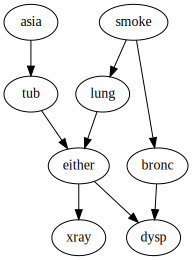

In [7]:
asia_model.write_dot("asia_model.dot")
graphviz.Source.from_file("asia_model.dot")

## Training

In [8]:
adam_params = {"lr": 0.005, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)

In [9]:
# train using SVI
start=time()
losses = asia_model.train(
    dataset=train_dataset, 
    optimizer=optimizer, 
    num_steps=10000,
    subsample_size=None,
    logdir="/tmp"
)
end=time()
print(f"training time is {end-start}")

 10%|▉         | 994/10000 [00:19<02:48, 53.32it/s]svi_step: 1000
elbo: 26274.056110203266
 20%|█▉        | 1999/10000 [00:38<02:32, 52.46it/s]svi_step: 2000
elbo: 19066.920685768127
 30%|██▉       | 2998/10000 [00:57<02:17, 50.77it/s]svi_step: 3000
elbo: 19420.979018211365
 40%|███▉      | 3994/10000 [01:17<01:54, 52.25it/s]svi_step: 4000
elbo: 18780.951974868774
 50%|████▉     | 4999/10000 [01:36<01:36, 51.59it/s]svi_step: 5000
elbo: 19089.620227336884
 60%|█████▉    | 5994/10000 [01:55<01:15, 52.81it/s]svi_step: 6000
elbo: 18634.833123207092
 70%|██████▉   | 6996/10000 [02:14<00:57, 52.33it/s]svi_step: 7000
elbo: 18166.83264052868
 80%|███████▉  | 7997/10000 [02:34<00:37, 53.50it/s]svi_step: 8000
elbo: 18115.5498380661
 90%|████████▉ | 8996/10000 [02:53<00:19, 52.72it/s]svi_step: 9000
elbo: 17967.185181856155
100%|█████████▉| 9997/10000 [03:11<00:00, 53.63it/s]svi_step: 10000
elbo: 17984.354870796204
100%|██████████| 10000/10000 [03:11<00:00, 52.09it/s]
training time: 191.9893310070

training time is 191.99339604377747


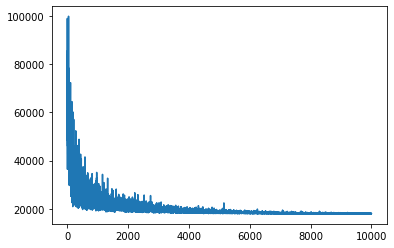

In [10]:
plt.plot(losses)

## Save to NET file
Write the MAP CPDs to a "NET" file and compare with the reference "NET" file.

In [11]:
asia_model.write_net("asia_model.net")
with open("asia_model.net", "rt") as f:
    print(f.read())

net
{
	name = asia;
}
node asia
{
	states = ("yes" "no");
}
node smoke
{
	states = ("yes" "no");
}
node tub
{
	states = ("yes" "no");
}
node lung
{
	states = ("yes" "no");
}
node either
{
	states = ("yes" "no");
}
node bronc
{
	states = ("yes" "no");
}
node xray
{
	states = ("yes" "no");
}
node dysp
{
	states = ("yes" "no");
}
potential ( asia | )
{
	data = (0.00983 0.99017);
}
potential ( smoke | )
{
	data = (0.49827 0.50173);
}
potential ( tub | asia)
{
	data = ((0.06301 0.93699) (0.01143 0.98857));
}
potential ( lung | smoke)
{
	data = ((0.09886 0.90114) (0.01118 0.98882));
}
potential ( either | lung tub)
{
	data = (((0.99735 0.00265) (0.99735 0.00265)) ((0.98898 0.01102) (0.00092 0.99908)));
}
potential ( bronc | smoke)
{
	data = ((0.59022 0.40978) (0.28573 0.71427));
}
potential ( xray | either)
{
	data = ((0.97721 0.02279) (0.05462 0.94538));
}
potential ( dysp | bronc either)
{
	data = (((0.90397 0.09603) (0.80802 0.19198)) ((0.70047 0.29953) (0.09049 0.90951)));
}



Note that due to the use of context specific independence, the following two CPDs are identical: 
- $P(either|lung=yes,tub=yes)$
- $P(either|lung=yes,tub=no)$

In [12]:
if not os.path.isfile("asia.net.gz"):
    urllib.request.urlretrieve("https://www.bnlearn.com/bnrepository/asia/asia.net.gz", "asia.net.gz")

with gzip.open("asia.net.gz", "rt") as f:
    print(f.read())

net 
{ 
}
node asia 
{
  states = ( "yes" "no" );
}
node tub 
{
  states = ( "yes" "no" );
}
node smoke 
{
  states = ( "yes" "no" );
}
node lung 
{
  states = ( "yes" "no" );
}
node bronc 
{
  states = ( "yes" "no" );
}
node either 
{
  states = ( "yes" "no" );
}
node xray 
{
  states = ( "yes" "no" );
}
node dysp 
{
  states = ( "yes" "no" );
}
potential ( asia ) 
{
  data = ( 0.01 0.99 );
}
potential ( tub | asia ) 
{
  data = ((0.05 0.95)(0.01 0.99)) ;
}
potential ( smoke ) 
{
  data = ( 0.5 0.5 );
}
potential ( lung | smoke ) 
{
  data = ((0.1 0.9)(0.01 0.99)) ;
}
potential ( bronc | smoke ) 
{
  data = ((0.6 0.4)(0.3 0.7)) ;
}
potential ( either | lung tub ) 
{
  data = (((1.0 0.0)(1.0 0.0))((1.0 0.0)(0.0 1.0))) ;
}
potential ( xray | either ) 
{
  data = ((0.98 0.02)(0.05 0.95)) ;
}
potential ( dysp | bronc either ) 
{
  data = (((0.9 0.1)(0.8 0.2))((0.7 0.3)(0.1 0.9))) ;
}



## Prediction

Let us use the model to predict the value of "tuberculosis" given other data.

In [13]:
true_labels = test_dataset["tub"].clone().detach()
test_dataset["tub"] = torch.zeros(len(test_dataset)) # zero out the labels in test-dataset

start=time()
_, prediction_MAP_assignment, _ = asia_model.predict(
    test_dataset, 
    ["tub"],
)
end=time()

accuracy = accuracy_score(true_labels.cpu().numpy(), prediction_MAP_assignment["tub"].cpu().numpy())

print(f"time taken for predictions is {end-start}")
print(f"accuracy is {accuracy}")

time taken for predictions is 1.0620810985565186
accuracy is 1.0
